In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [2]:
df_q = pd.read_excel("./data/data_flat.xlsx",sheet_name="QT_index")
df_p = pd.read_excel("./data/data_flat.xlsx",sheet_name="P_index")
df_w = pd.read_excel("./data/data_flat.xlsx",sheet_name="weights")

In [3]:
df_q.replace("European Union - 27 countries (from 2020)","EU27",inplace=True)
df_p.replace("European Union - 27 countries (from 2020)","EU27",inplace=True)
df_p = df_p.drop(['2023-10'],axis=1)
df_w.replace("European Union - 27 countries (from 2020)","EU27",inplace=True)



In [4]:
class CPIframe:
    def __init__(self, df_q, df_p, df_w, country):
        """
        Args:
            df_q (DataFrame): The Quantity data.
            df_p (DataFrame): The Price data.
            df_w (DataFrame): The respective Weights data.
            country (str): Location available (EU27,France,Germany,Spain).
        """
        self.country = country
        self.df_q = df_q
        self.df_p = df_p
        self.df_w = df_w
        self.sectors = dict(self.price().loc['HICP'])
    
    def qt(self):
        """
        Generates a subset of the dataframe `df_q` based on the specified `country`.
        Parameters:
            self (object): The current instance of the class `CPI`.
        Returns:
            pandas.DataFrame: Dataframe of Quantity series data with dates as rows.
        """
        x = self.df_q[self.df_q['Location']==self.country]
        x.reset_index(drop=True,inplace=True)
        x = x.drop(['Location'],axis=1)
        x = x.transpose()
        return x
    
    def price(self):
        """
        Generates a subset of the dataframe `df_p` based on the specified `country`.
        Parameters:
            self (object): The current instance of the class `CPI`.
        Returns:
            pandas.DataFrame: Dataframe of Price series data with dates as rows
        """
        x = self.df_p[self.df_p['Location']==self.country]
        x.reset_index(drop=True,inplace=True)
        x = x.drop(['Location'],axis=1)
        x = x.transpose()
        return x
    
    def weights(self):
        x = self.df_w[self.df_w['Location']==self.country]
        x.reset_index(drop=True,inplace=True)
        x = x.drop(['Location'],axis=1)
        x = x.transpose()
        return x
    
    def sector(self,col_num,transform=True,log=False):
        """
        Generates a two column [price,quantity] for the specified sector.
        Parameters:
            self (object): The current instance of the class `CPI`.
            col_num: column number in `price` & `qt` objects for the sector of interest.
            transform: 100*first diff then demean
        Returns:
            pandas.DataFrame: Dataframe of Quantity series data with dates as rows
        """
        x = pd.concat([self.price()[col_num],self.qt()[col_num]],axis=1)
        sec = list(x.loc['HICP'])[-1]
        x = x.drop(['HICP'],axis=0)
        x.columns = ['price','qt']
        x = x.apply(pd.to_numeric)
        
        if log:
            x = np.log(x)
            x = x.dropna()
        
        if transform:
            x = 100*x.diff() 
            x = x - x.mean()
            x = x.dropna()
        x = x.dropna()
        #x.subdates = list(x.index)
        #x.reset_index(drop=True,inplace=True)
        return x



In [5]:
eu = CPIframe(df_q,df_p,df_w,'EU27')
eu.sector(54)

,price,qt
2001-01,-1.332519,1.123752
2001-02,0.144613,-1.008777
2001-03,-0.525830,1.332512
2001-04,1.700279,0.401442
2001-05,-1.260985,-0.685522
...,...,...
2023-04,7.299541,-7.635559
2023-05,-1.799166,1.336602
2023-06,1.285962,-2.312366
2023-07,5.814991,-6.106046


## Stationarity tests

In [6]:
def statio(eu,log_bool,transform_bool):
    price=  []
    qt = []
    idx=[]
    PER_SIGN = []
    for trend in ['c','ct','ctt']:
        for k in range(72):
            sect_k = (eu.sector(k,log=log_bool,transform=transform_bool)).reset_index()[['price','qt']]
            try:
                p_value_price = adfuller(sect_k.price,regression=trend)[1]
                p_value_qt = adfuller(sect_k.qt,regression=trend)[1]
                price.append(p_value_price)
                qt.append(p_value_qt)
                idx.append(k)
            except:
                None
        df = pd.DataFrame(data=[price,qt]).T
        df.columns=['price','qt']
        df.index = idx
        for cat in ['price','qt']:
            for per in [1,5,10]:
                name = 'sign_'+str(per)+'per'+'_'+cat
                df[name] = df[cat].apply(lambda x: x<per/100)
        PER_SIGN.append(100*df[df.columns[-6:]].sum()/len(df))
    return pd.DataFrame(data=PER_SIGN,index=['c','ct','ctt'])
        
        
        
    

In [7]:
results = statio(eu,True,True)

In [8]:
results

,sign_1per_price,sign_5per_price,sign_10per_price,sign_1per_qt,sign_5per_qt,sign_10per_qt
c,46.938776,63.265306,65.306122,93.877551,95.918367,95.918367
ct,43.877551,61.224490,65.306122,93.877551,95.918367,97.959184
ctt,40.816327,60.544218,63.945578,92.517007,95.238095,97.278912


## Lag Selection

In [9]:
def hist(crit,n):
    L =[]
    for k in range(72):
        data = eu.sector(k)
        model = VAR(data)
        try:
            L.append(model.select_order(maxlags=n,trend='c').selected_orders[crit])
        except:
            None

    return L

In [10]:
#getting rid of value warnings: 
import warnings
warnings.filterwarnings('ignore')

In [11]:
AIC = hist('aic',12)

In [12]:
for k in range(1,13):
    print(k,100*AIC.count(k)/len(AIC))
    

1 2.0408163265306123
2 6.122448979591836
3 6.122448979591836
4 2.0408163265306123
5 0.0
6 4.081632653061225
7 0.0
8 2.0408163265306123
9 6.122448979591836
10 4.081632653061225
11 2.0408163265306123
12 65.3061224489796


(array([ 4.,  3.,  1.,  0.,  2.,  0.,  1.,  3.,  2., 33.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

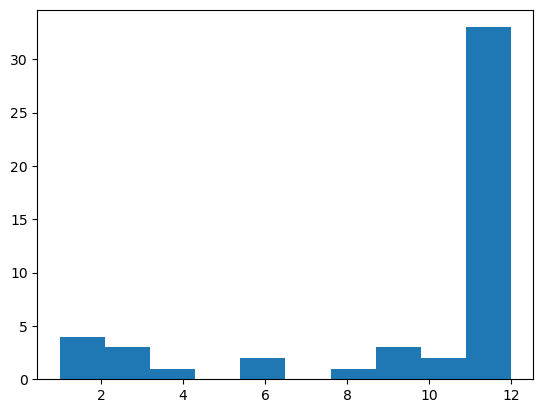

In [13]:
plt.hist(AIC)

In [14]:
BIC = hist('bic',12)

(array([10., 17.,  3.,  0.,  0.,  1.,  3.,  1.,  0., 14.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

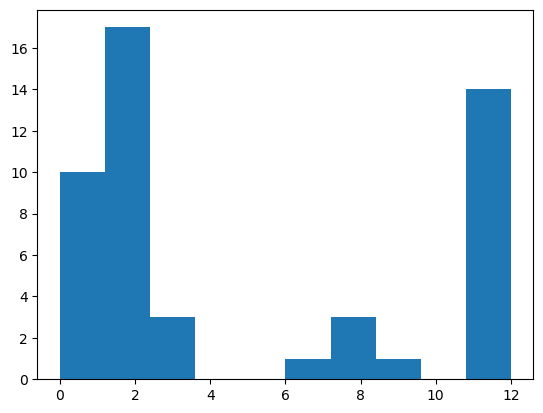

In [15]:
plt.hist(BIC)

In [16]:
for k in range(1,13):
    print(k,100*BIC.count(k)/len(BIC))
    

1 14.285714285714286
2 34.69387755102041
3 6.122448979591836
4 0.0
5 0.0
6 2.0408163265306123
7 0.0
8 6.122448979591836
9 2.0408163265306123
10 0.0
11 2.0408163265306123
12 26.53061224489796


In [17]:
AIC_24 = hist('aic',24)

(array([ 7.,  0.,  0.,  5.,  6.,  6.,  4.,  1.,  1., 19.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

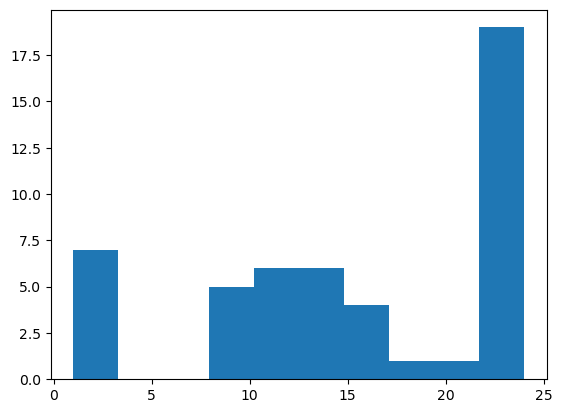

In [18]:
plt.hist(AIC_24)

In [19]:
for k in range(1,25):
    print(k,100*AIC_24.count(k)/len(AIC_24))
    

1 2.0408163265306123
2 6.122448979591836
3 6.122448979591836
4 0.0
5 0.0
6 0.0
7 0.0
8 2.0408163265306123
9 2.0408163265306123
10 6.122448979591836
11 0.0
12 12.244897959183673
13 6.122448979591836
14 6.122448979591836
15 8.16326530612245
16 0.0
17 0.0
18 0.0
19 2.0408163265306123
20 2.0408163265306123
21 0.0
22 0.0
23 8.16326530612245
24 30.612244897959183


In [20]:
BIC_24 = hist('bic',24)

(array([12., 14.,  4.,  0.,  1.,  3.,  1.,  1., 12.,  1.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

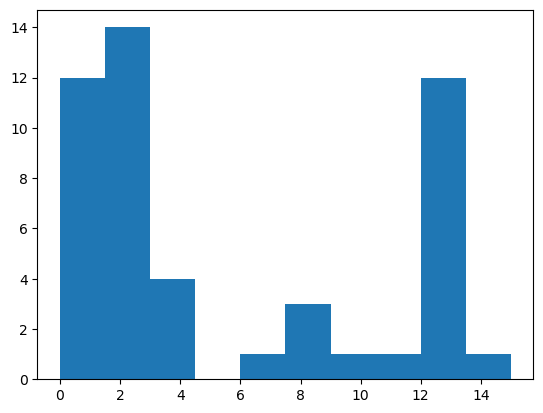

In [21]:
plt.hist(BIC_24)

In [22]:
for k in range(1,25):
    print(k,100*BIC_24.count(k)/len(BIC_24))
    

1 20.408163265306122
2 28.571428571428573
3 8.16326530612245
4 0.0
5 0.0
6 2.0408163265306123
7 0.0
8 6.122448979591836
9 2.0408163265306123
10 0.0
11 2.0408163265306123
12 22.448979591836736
13 2.0408163265306123
14 0.0
15 2.0408163265306123
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0


## Residuals

In [23]:
test = eu.sector(54)

In [24]:
model = VAR(test)

In [25]:
results = model.fit(12)

In [26]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Jan, 2024
Time:                     17:55:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.93625
Nobs:                     260.000    HQIC:                   3.52678
Log likelihood:          -1110.54    FPE:                    25.8600
AIC:                      3.25150    Det(Omega_mle):         21.5221
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.005219         0.093037           -0.056           0.955
L1.price         -0.289836         0.060055           -4.826           0.000
L1.qt             0.007718         0.030869            0.250           0.803

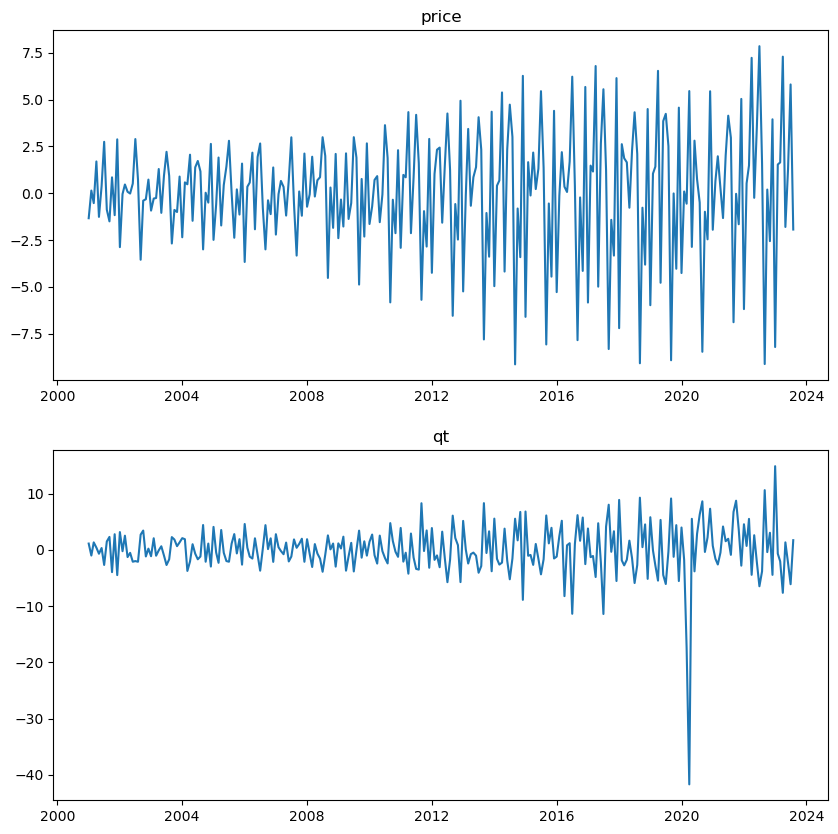

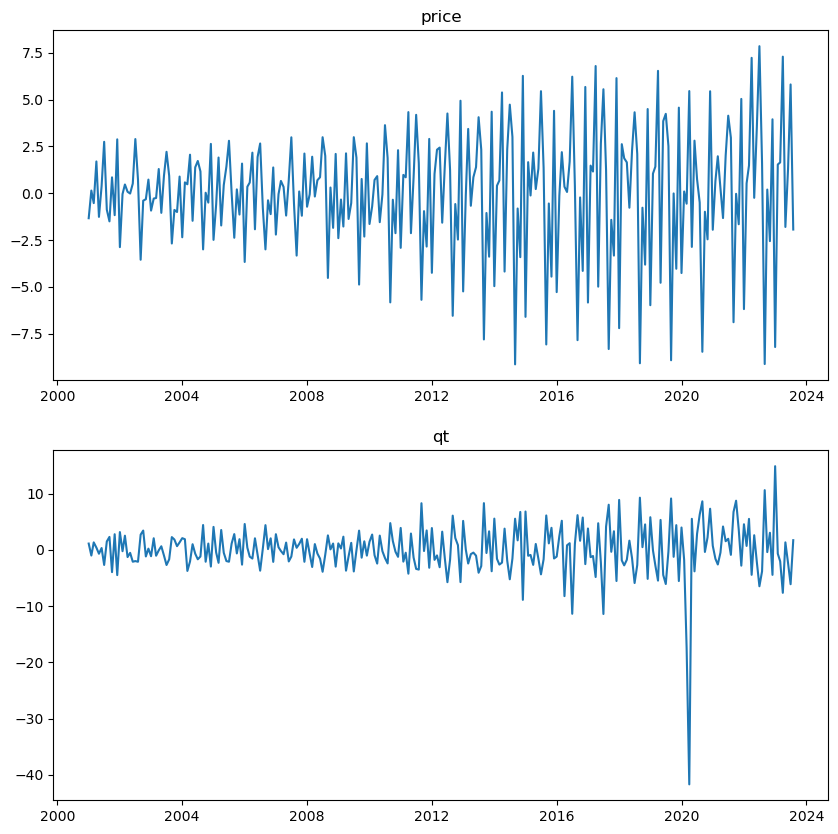

In [27]:
results.plot()

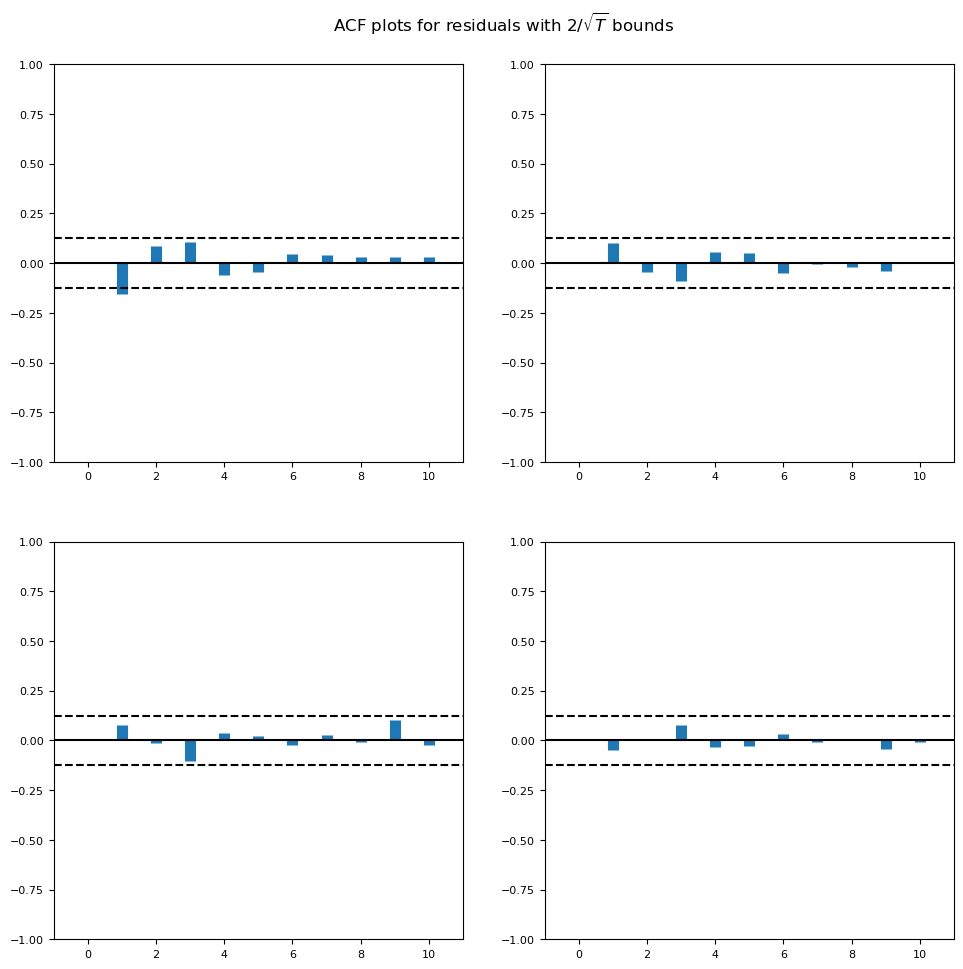

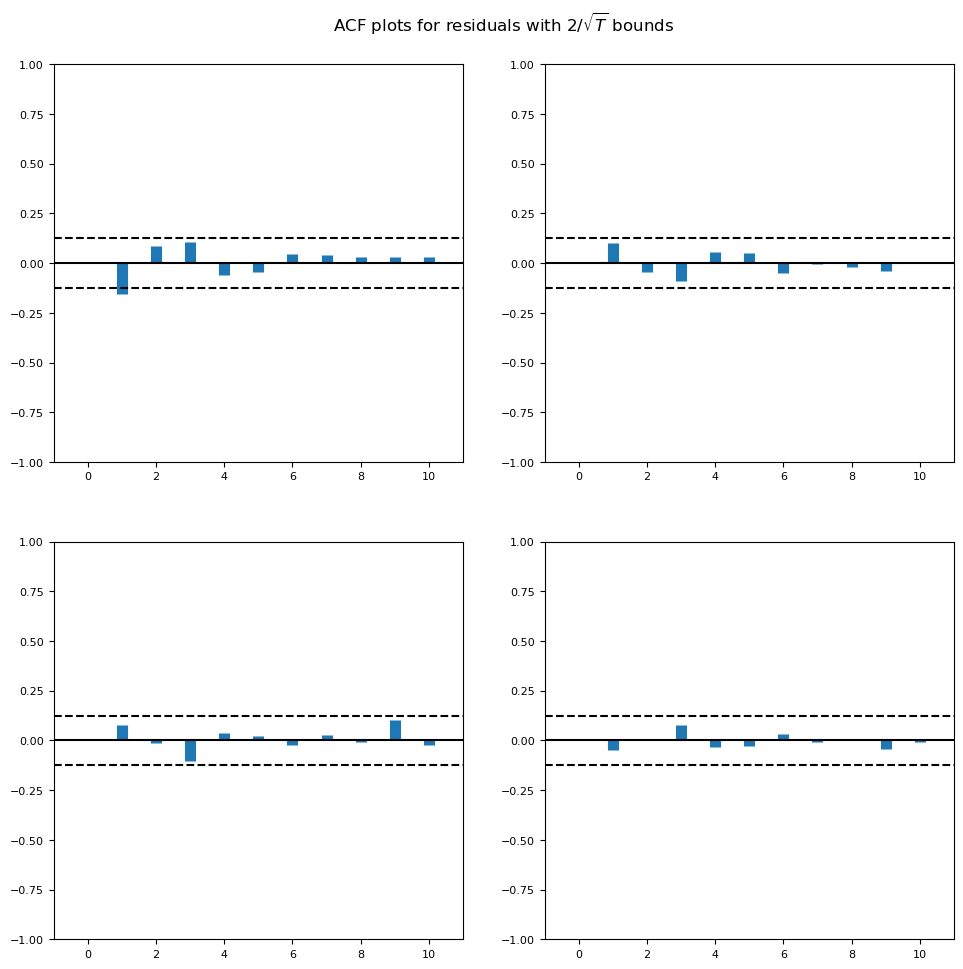

In [28]:
results.plot_acorr()

In [29]:
results.params

,price,qt
const,-0.005219,0.037041
L1.price,-0.289836,0.496843
L1.qt,0.007718,0.162110
L2.price,-0.118566,0.128429
L2.qt,0.035422,0.001210
L3.price,-0.278610,0.031233
L3.qt,0.032476,-0.033929
L4.price,-0.110016,0.100850
L4.qt,0.109725,-0.143320
L5.price,-0.161071,0.256833


In [30]:
qt_params = results.params.loc[[results.params.index[1:][2*k+1] for k in range(12)]].reset_index()

In [31]:
pt_params = results.params.loc[[results.params.index[1:][2*k] for k in range(12)]].reset_index()

In [32]:
#np.dot(pt_params.price,test[:12].price)

In [33]:
def reg_resid(data,qt_params,pt_params,cons,cat):
    if cat=='price':
        return cons.price + np.dot(pt_params.price,data.price) + np.dot(pt_params.qt,data.qt)
    else:
        return cons.qt +  np.dot(qt_params.qt,data.qt) + np.dot(qt_params.price,data.price)
    
    

In [34]:
def resid(data,results):
    n=len(data)
    Price_resid=[]
    QT_resid = []
    qt_params = results.params.loc[[results.params.index[1:][2*k+1] for k in range(12)]].reset_index()
    pt_params = results.params.loc[[results.params.index[1:][2*k] for k in range(12)]].reset_index()
    cons = results.params.loc['const']
    for k in range(12,n):
        data_point = data.T[k]
        data_ = data[k-12:k].iloc[::-1]
        resid_price = data_point.price - reg_resid(data_,qt_params,pt_params,cons,'price')
        resid_qt = data_point.qt - reg_resid(data_,qt_params,pt_params,cons,'qt')
        Price_resid.append(resid_price)
        QT_resid.append(resid_qt)
    df_resid = pd.DataFrame(data=[Price_resid,QT_resid]).T
    df_resid.columns = ['price','qt']
    df_resid['sign'] = df_resid.apply(lambda t: 1-2*int(t.price*t.qt<0),axis=1)
    return df_resid
        

In [35]:
eu.sector(19)

,price,qt


In [36]:
for k in range(72):
    try:
        data = (eu.sector(k)).reset_index()[['price','qt']]
        model = VAR(data)
        results = model.fit(12)
        resid_ = resid(data,results)
        name = 'residuals' + str(k) + '.csv'
        resid_.to_csv(name)
    except:
        print('val error '+str(k))

    
    

val error 19
val error 20
val error 22
val error 23
val error 29
val error 30
val error 33
val error 34
val error 36
val error 38
val error 39
val error 40
val error 41
val error 42
val error 43
val error 45
val error 46
val error 47
val error 57
val error 59
val error 60
val error 66
val error 67


In [37]:
resid_

,price,qt,sign
0,0.522415,-1.457033,-1
1,-0.917672,-1.742443,1
2,-0.600146,0.259601,-1
3,-0.777620,-0.296062,1
4,0.338520,-0.208946,-1
...,...,...,...
255,-0.359394,-0.308134,1
256,0.161070,-0.457775,-1
257,-0.125845,0.033444,-1
258,0.314649,-0.276237,-1


In [38]:
resid_['sign'] = resid_.apply(lambda t: 1-2*int(t.price*t.qt<0),axis=1)

<AxesSubplot:>

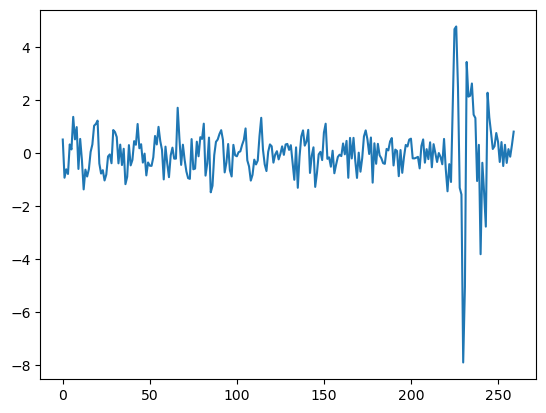

In [39]:
resid_.price.plot()

<AxesSubplot:>

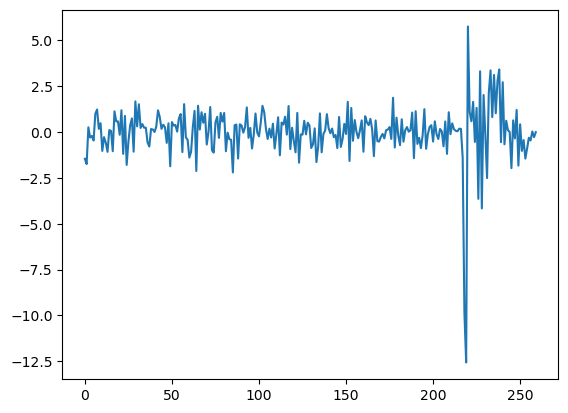

In [40]:
resid_.qt.plot()